<a href="https://colab.research.google.com/github/Theekshana-se/Air-QualityPredict-DeepLearningProject/blob/1D_CNN/IT22608086_1D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Air Quality Prediction in India with 1D CNN

This notebook rewrites the earlier temperature 1D‑CNN project to predict **Air Quality** using the file `data.csv`. It keeps the same flow, but all steps and explanations now target **AQI or PM2.5** prediction.

**Main sections**

1. Loading and Exploring the Air Quality Dataset  
2. Data Preprocessing and Feature Engineering  
3. 1D CNN Model Architecture for Air Quality Prediction  
4. Training the Air Quality Prediction Model  
5. Model Evaluation and Performance Analysis  
6. Making Air Quality Predictions  
7. Data Visualization and Correlation Analysis

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Setup and imports

In [48]:
# If you are on Colab and need libraries, uncomment the next line
# !pip -q install tensorflow scikit-learn pandas numpy matplotlib

import os
import math
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

np.random.seed(42)
tf.random.set_seed(42)

print(tf.__version__)

2.19.0


## 1) Loading and Exploring the Air Quality Dataset

**Goals**

- Load `data.csv`  
- Show the first rows, info, and summary stats  
- Describe key columns such as `City`, `Date`, `PM2.5`, `PM10`, `NO2`, `SO2`, `O3`, `AQI`

In [49]:
# Path handling: prefer Colab path, then fall back to local file in this workspace
CSV_PATH = "/content/drive/MyDrive/data.csv"
FALLBACK = "/mnt/data/data.csv"
if not os.path.exists(CSV_PATH) and os.path.exists(FALLBACK):
    CSV_PATH = FALLBACK

assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}. Please mount Drive or update CSV_PATH."

# Load dataset with a safe reader
# Tries plain read first, then fallback engines if needed
def safe_read_csv(path):
    try:
        return pd.read_csv(path)
    except Exception as e:
        try:
            return pd.read_csv(path, engine="python")
        except Exception as e2:
            # Last resort with common encodings
            for enc in ["utf-8", "latin-1", "cp1252"]:
                try:
                    return pd.read_csv(path, encoding=enc, engine="python")
                except Exception:
                    continue
    raise RuntimeError("Could not read CSV with standard options. Inspect file formatting.")

df_raw = safe_read_csv(CSV_PATH)
print("Shape:", df_raw.shape)
display(df_raw.head(10))
print("\\nInfo:")
print(df_raw.info())
print("\\nSummary:")
display(df_raw.describe(include="all").transpose().head(30))

# Light guidance printout for expected columns
expected = ["City","Date","PM2.5","PM10","NO2","SO2","O3","AQI"]
print("\\nColumns present:", list(df_raw.columns)[:40])
print("Look for key columns such as:", expected)

Shape: (435742, 13)


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01
5,152,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.4,25.7,NaN,NaN,NaN,NaN,1990-03-01
6,150,April - M041990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",5.4,17.1,NaN,NaN,NaN,NaN,1990-04-01
7,151,April - M041990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,8.7,NaN,NaN,NaN,NaN,1990-04-01
8,152,April - M041990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.2,23.0,NaN,NaN,NaN,NaN,1990-04-01
9,151,May - M051990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.0,8.9,NaN,NaN,NaN,NaN,1990-05-01


\nInfo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  obje

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
stn_code,291665,745,193,1428,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sampling_date,435739,5485,19-03-15,253,NaN,NaN,NaN,NaN,NaN,NaN,NaN
state,435742,37,Maharashtra,60384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
location,435739,304,Guwahati,9984,NaN,NaN,NaN,NaN,NaN,NaN,NaN
agency,286261,64,Maharashtra State Pollution Control Board,27857,NaN,NaN,NaN,NaN,NaN,NaN,NaN
type,430349,10,"Residential, Rural and other Areas",179014,NaN,NaN,NaN,NaN,NaN,NaN,NaN
so2,401096.0,NaN,NaN,NaN,10.829414,11.177187,0.0,5.0,8.0,13.7,909.0
no2,419509.0,NaN,NaN,NaN,25.809623,18.503086,0.0,14.0,22.0,32.2,876.0
rspm,395520.0,NaN,NaN,NaN,108.832784,74.87243,0.0,56.0,90.0,142.0,6307.033333
spm,198355.0,NaN,NaN,NaN,220.78348,151.395457,0.0,111.0,187.0,296.0,3380.0


\nColumns present: ['stn_code', 'sampling_date', 'state', 'location', 'agency', 'type', 'so2', 'no2', 'rspm', 'spm', 'location_monitoring_station', 'pm2_5', 'date']
Look for key columns such as: ['City', 'Date', 'PM2.5', 'PM10', 'NO2', 'SO2', 'O3', 'AQI']


## 2) Data Preprocessing and Feature Engineering

**What we do here**

- Clean column names  
- Parse the `Date` column to datetime  
- Extract time features such as year, month, day, day of week, hour if present  
- Handle missing values  
- Scale features  
- Split into train and test by time where possible  
- Prepare sequences for 1D CNN input

In [50]:
# ----- Column standardization -----
df = df_raw.copy()

# Unify column names for robust access
df.columns = [c.strip().replace(" ", "_").replace("-", "_") for c in df.columns]

# Try to locate the date column by common names
date_candidates = ["Date", "date", "DATE", "timestamp", "Timestamp", "Datetime", "datetime"]
date_col = None
for cand in date_candidates:
    for c in df.columns:
        if c.lower() == cand.lower():
            date_col = c
            break
    if date_col is not None:
        break

if date_col is None:
    raise ValueError("Date column not found. Please rename the date column to 'Date' or a common variant.")

# Parse datetime
df[date_col] = pd.to_datetime(df[date_col], errors="coerce")
df = df.sort_values(by=[date_col]).reset_index(drop=True)

# Identify pollutants and AQI columns by common names
# We pick target as PM2.5 if available, else AQI
pollutant_aliases = {
    "PM2.5": ["PM2.5","PM25","pm2_5","pm25","PM_2_5"],
    "PM10":  ["PM10","pm10","PM_10"],
    "NO2":   ["NO2","no2","NO_2"],
    "SO2":   ["SO2","so2","SO_2"],
    "O3":    ["O3","o3","O_3","Ozone","ozone"],
    "AQI":   ["AQI","aqi"]
}

def find_col(dfcols, aliases):
    for name in aliases:
        for c in dfcols:
            if c.lower() == name.lower().replace(" ", "_"):
                return c
    return None

cols_found = {}
for key, aliases in pollutant_aliases.items():
    cols_found[key] = find_col(df.columns, aliases)

# Choose target
TARGET = cols_found.get("PM2.5") or cols_found.get("AQI")
if TARGET is None:
    # If neither found, try a simple heuristic: pick the most likely pollutant-like column
    candidates = [c for c in df.columns if any(tok in c.lower() for tok in ["pm2", "aqi", "target"])]
    TARGET = candidates[0] if candidates else None

if TARGET is None:
    raise ValueError("Could not locate PM2.5 or AQI. Please check your columns.")

print("Target column:", TARGET)
print("Detected columns:", cols_found)

# ----- Basic feature engineering -----
# Create basic time features
df["year"] = df[date_col].dt.year
df["month"] = df[date_col].dt.month
df["day"] = df[date_col].dt.day
df["dayofweek"] = df[date_col].dt.dayofweek
if not pd.isna(df[date_col].dt.hour).all():
    df["hour"] = df[date_col].dt.hour
else:
    df["hour"] = 0

# If a city column exists, keep it for grouping. Try common names.
city_candidates = ["City","city","Location","location","Station","station"]
city_col = None
for cand in city_candidates:
    for c in df.columns:
        if c.lower() == cand.lower():
            city_col = c
            break
    if city_col is not None:
        break

# ----- Handle missing values -----
# Numeric columns: interpolate then forward/back fill
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
df[num_cols] = df[num_cols].interpolate(method="linear", limit_direction="both")
df[num_cols] = df[num_cols].fillna(method="ffill").fillna(method="bfill")

# Categorical columns: fill with mode
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
for c in cat_cols:
    if df[c].isna().any():
        df[c] = df[c].fillna(df[c].mode().iloc[0])

# ----- Feature set -----
feature_cols = []
for key in ["PM2.5","PM10","NO2","SO2","O3","AQI"]:
    c = cols_found.get(key)
    if c is not None and c != TARGET:
        feature_cols.append(c)

# Add time features
feature_cols += ["year","month","day","dayofweek","hour"]

# Avoid duplicates and ensure existence
feature_cols = [c for c in dict.fromkeys(feature_cols) if c in df.columns]

print("Feature columns:", feature_cols)

# ----- Frequency inference for window size -----
# If timestamps have at least two values, estimate step to pick a window
if df[date_col].notna().sum() >= 2:
    deltas = df[date_col].diff().dropna().dt.total_seconds()
    median_step = deltas.median() if len(deltas) else None
else:
    median_step = None

# Choose window size: daily data → 30, hourly → 24
if median_step is None:
    WINDOW = 30
else:
    # If step <= 3 hours treat as hourly
    WINDOW = 24 if median_step <= 3*3600 else 30

HORIZON = 1  # predict next step

print(f"Inferred median step (sec): {median_step}, WINDOW={WINDOW}, HORIZON={HORIZON}")

# ----- Build supervised sequences -----
def build_sequences(df_group):
    # Sort within group
    df_group = df_group.sort_values(by=[date_col]).reset_index(drop=True)
    values = df_group[feature_cols + [TARGET]].values.astype(float)

    X_list, y_list, ts_list = [], [], []
    for i in range(len(values) - WINDOW - HORIZON + 1):
        x_win = values[i:i+WINDOW, :len(feature_cols)]
        y_val = values[i+WINDOW + HORIZON - 1, -1]  # target at horizon
        X_list.append(x_win)
        y_list.append(y_val)
        ts_list.append(df_group.loc[i+WINDOW + HORIZON - 1, date_col])
    return np.array(X_list), np.array(y_list), pd.Series(ts_list)

# Group by city if present, else one group
groups = []
if city_col:
    for name, g in df.groupby(city_col):
        if len(g) >= WINDOW + HORIZON + 5:
            groups.append(g.copy())
else:
    groups.append(df.copy())

X_all, y_all, t_all = [], [], []
for g in groups:
    Xg, yg, tg = build_sequences(g)
    if len(Xg) > 0:
        X_all.append(Xg); y_all.append(yg); t_all.append(tg)

if not X_all:
    raise ValueError("Not enough rows to build sequences. Try a smaller WINDOW or check the date continuity.")

X = np.vstack(X_all)
y = np.concatenate(y_all)
tidx = pd.concat(t_all).reset_index(drop=True)

print("X shape before scaling:", X.shape)  # (samples, window, features)
print("y shape:", y.shape)

# ----- Train / Test split by time -----
# Use the last 20 percent as test set to respect time order
n = len(X)
split_idx = int(n * 0.8)
Xtr, Xte = X[:split_idx], X[split_idx:]
ytr, yte = y[:split_idx], y[split_idx:]
ttr, tte = tidx[:split_idx], tidx[split_idx:]

# ----- Scale features and target -----
# Fit scalers on training only
x_scaler = StandardScaler()
Xtr_2d = Xtr.reshape(-1, Xtr.shape[-1])
Xte_2d = Xte.reshape(-1, Xte.shape[-1])

x_scaler.fit(Xtr_2d)
Xtr_s = x_scaler.transform(Xtr_2d).reshape(Xtr.shape)
Xte_s = x_scaler.transform(Xte_2d).reshape(Xte.shape)

y_scaler = StandardScaler().fit(ytr.reshape(-1,1))
ytr_s = y_scaler.transform(ytr.reshape(-1,1)).ravel()
yte_s = y_scaler.transform(yte.reshape(-1,1)).ravel()

print("Train shapes:", Xtr_s.shape, ytr_s.shape)
print("Test shapes:",  Xte_s.shape, yte_s.shape)

Target column: pm2_5
Detected columns: {'PM2.5': 'pm2_5', 'PM10': None, 'NO2': 'no2', 'SO2': 'so2', 'O3': None, 'AQI': None}
Feature columns: ['no2', 'so2', 'year', 'month', 'day', 'dayofweek', 'hour']
Inferred median step (sec): 0.0, WINDOW=24, HORIZON=1
X shape before scaling: (428495, 24, 7)
y shape: (428495,)
Train shapes: (342796, 24, 7) (342796,)
Test shapes: (85699, 24, 7) (85699,)


## 3) 1D CNN Model Architecture for Air Quality Prediction

We build a Sequential 1D CNN with `Conv1D`, `MaxPooling1D`, `Flatten`, `Dense`, and `Dropout`.  
Optimizer is `adam`, loss is `mse` for regression.

In [51]:
keras.backend.clear_session()

model = keras.Sequential([
    layers.Input(shape=(Xtr_s.shape[1], Xtr_s.shape[2])),
    layers.Conv1D(filters=64, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Conv1D(filters=128, kernel_size=3, activation="relu", padding="causal"),
    layers.MaxPooling1D(pool_size=2),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.25),
    layers.Dense(1)  # regression
])

model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 24, 64)         │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 12, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 12, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        98,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 124,673 (487.00 KB)

 Trainable params: 124,673 (487.00 KB)

 Non-trainable params: 0 (0.00 B)

## 4) Training the Air Quality Prediction Model

We train with early stopping and learning rate reduction on plateau.  
The plot shows training and validation loss over epochs.

Epoch 1/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 49s 22ms/step - loss: 0.4845 - val_loss: 0.3428 - learning_rate: 0.0010
Epoch 2/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - loss: 0.3725 - val_loss: 0.3368 - learning_rate: 0.0010
Epoch 3/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - loss: 0.3606 - val_loss: 0.3360 - learning_rate: 0.0010
Epoch 4/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 44s 21ms/step - loss: 0.3548 - val_loss: 0.3341 - learning_rate: 0.0010
Epoch 5/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - loss: 0.3512 - val_loss: 0.3381 - learning_rate: 0.0010
Epoch 6/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - loss: 0.3466 - val_loss: 0.3338 - learning_rate: 0.0010
Epoch 7/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 44s 20ms/step - loss: 0.3434 - val_loss: 0.3356 - learning_rate: 0.0010
Epoch 8/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 46s 22ms/step - loss: 0.3421 - val_loss: 0.3309 - learning_rate: 0.0010
Epoch 9/100
2143/2143 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step - loss: 0.3383 - val_lo

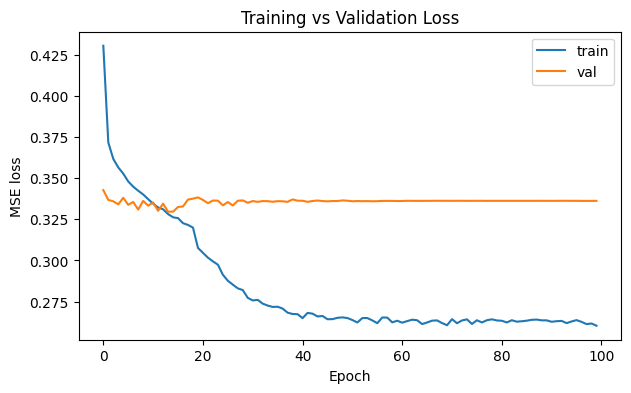

In [52]:
es = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
rlr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6)

mckpt = keras.callbacks.ModelCheckpoint(
    "best_model.keras", monitor="val_loss", save_best_only=True
)

hist = model.fit(
    Xtr_s, ytr_s,
    validation_split=0.2,
    epochs=100,
    batch_size=128,
    callbacks=[mckpt, rlr],   # <-- removed 'es'
    verbose=1
)
# After training, load best if you want:
# model = keras.models.load_model("best_model.keras")


# Plot history with matplotlib only
h = pd.DataFrame(hist.history)
plt.figure(figsize=(7,4))
plt.plot(h["loss"], label="train")
plt.plot(h["val_loss"], label="val")
plt.xlabel("Epoch")
plt.ylabel("MSE loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

## 5) Model Evaluation and Performance Analysis

We evaluate with **MAE**, **RMSE**, and **R²** in original units of the selected target.  
We also compare actual and predicted values on the test range.

Target: pm2_5
Test RMSE: 12.003
Test MAE : 3.926
Test R^2 : 0.656


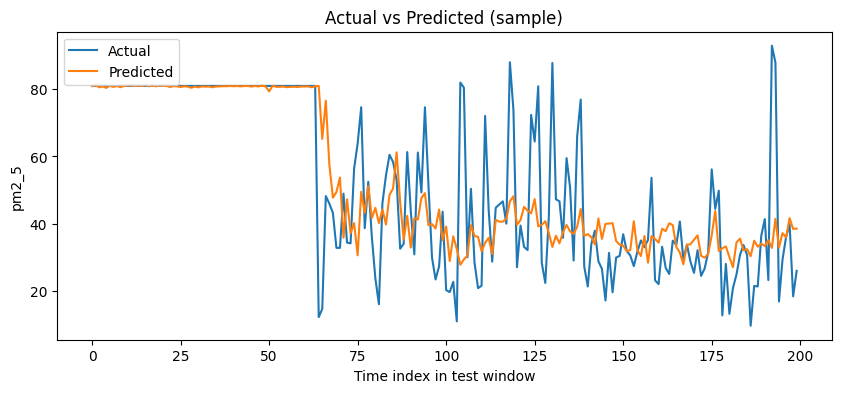

,timestamp,actual,predicted
0,2013-08-30,81.0,80.930351
1,2013-09-01,81.0,81.216072
2,2013-09-01,81.0,80.573708
3,2013-09-05,81.0,80.826622
4,2013-09-09,81.0,80.404778
5,2013-09-09,81.0,81.029160
6,2013-09-12,81.0,80.699806
7,2013-09-12,81.0,80.981026
8,2013-09-13,81.0,80.618088
9,2013-09-16,81.0,80.969269


In [66]:
# Predict on test set and invert scaling
y_pred_s = model.predict(Xte_s, verbose=0).ravel()
y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
y_true = yte  # already in original units

rmse = math.sqrt(mean_squared_error(y_true, y_pred))
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)

print(f"Target: {TARGET}")
print(f"Test RMSE: {rmse:.3f}")
print(f"Test MAE : {mae:.3f}")
print(f"Test R^2 : {r2:.3f}")

# Plot a short segment for clarity
k = min(200, len(y_true))
plt.figure(figsize=(10,4))
plt.plot(range(k), y_true[:k], label="Actual")
plt.plot(range(k), y_pred[:k], label="Predicted")
plt.xlabel("Time index in test window")
plt.ylabel(TARGET)
plt.title("Actual vs Predicted (sample)")
plt.legend()
plt.show()

# Tabular comparison for the test set
out_df = pd.DataFrame({
    "timestamp": tte.values,
    "actual": y_true,
    "predicted": y_pred
})
display(out_df.head(20))

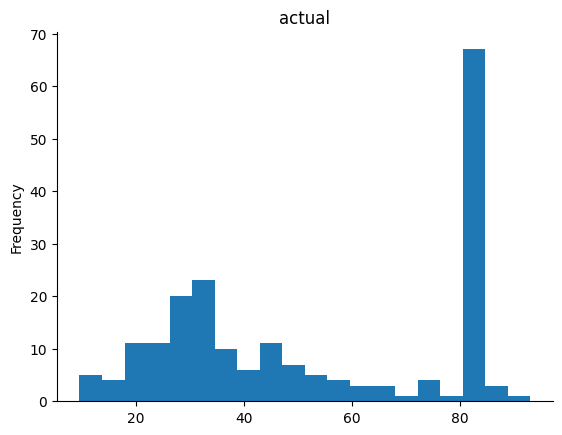

In [54]:
from matplotlib import pyplot as plt
_df_0['actual'].plot(kind='hist', bins=20, title='actual')
plt.gca().spines[['top', 'right',]].set_visible(False)

## 6) Making Air Quality Predictions

This section uses the trained model to predict the next step on the test windows.  


,timestamp,actual,predicted
85679,2009-07-28,81.0,80.975571
85680,2009-08-01,81.0,80.977348
85681,2009-08-07,81.0,80.941772
85682,2009-08-19,81.0,80.955574
85683,2009-08-25,81.0,80.965698
85684,2009-08-26,81.0,80.964531
85685,2009-09-06,81.0,80.952721
85686,2009-09-11,81.0,80.918045
85687,2009-10-02,81.0,80.951004
85688,2009-11-02,81.0,80.906235


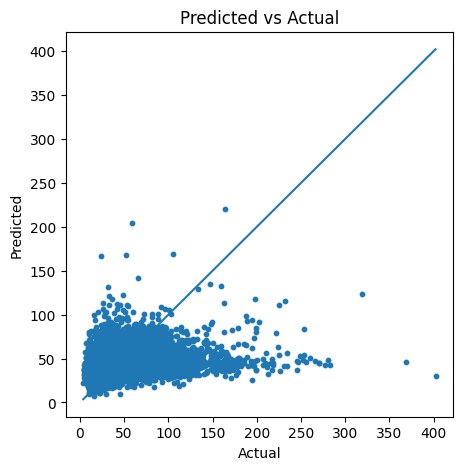

In [60]:
# Already computed y_pred above. For convenience, show full comparison again.
display(out_df.tail(20))

# If you want a simple scatter of predicted vs actual
plt.figure(figsize=(5,5))
plt.scatter(y_true, y_pred, s=10)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
# 45-degree reference
mn, mx = min(y_true.min(), y_pred.min()), max(y_true.max(), y_pred.max())
plt.plot([mn, mx], [mn, mx])
plt.show()

## 7) Data Visualization and Correlation Analysis

We visualize relationships among air quality variables and trends over time.

- Correlation heatmap among available pollutant columns and AQI  
- Bar plot of monthly average for the chosen target  
- Scatter plot of PM2.5 vs PM10, or AQI vs NO2 if PM10 is missing

All charts use `matplotlib` only.

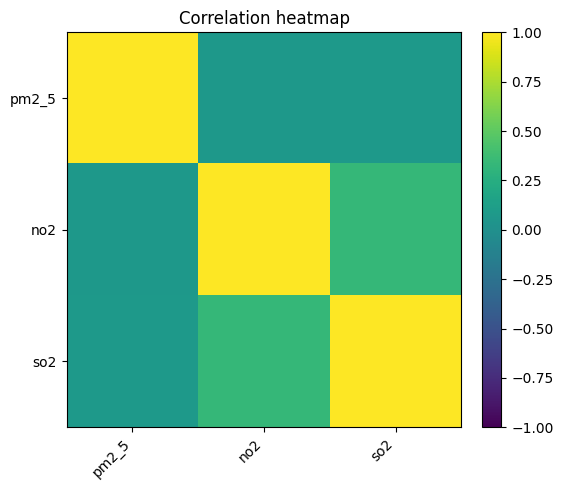

In [56]:
# Choose columns for correlation
corr_candidates = []
for key in ["PM2.5","PM10","NO2","SO2","O3","AQI"]:
    c = cols_found.get(key)
    if c is not None and c in df.columns:
        corr_candidates.append(c)

corr_candidates = list(dict.fromkeys(corr_candidates))  # unique
if len(corr_candidates) >= 2:
    corr_data = df[corr_candidates].astype(float)
    C = np.corrcoef(corr_data.values.T)
    labels = corr_candidates

    plt.figure(figsize=(6,5))
    im = plt.imshow(C, vmin=-1, vmax=1)
    plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
    plt.yticks(range(len(labels)), labels)
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.title("Correlation heatmap")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough pollutant columns for a correlation heatmap.")

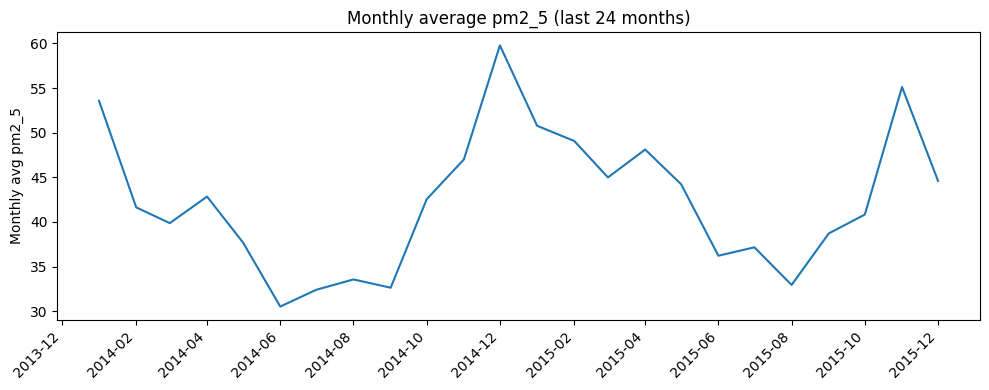

In [57]:
last_n = 24
mm_tail = monthly_mean.tail(last_n)

fig, ax = plt.subplots(figsize=(10, 4))
ax.plot(mm_tail.index, mm_tail.values, linewidth=1.5)
ax.set_title(f"Monthly average {TARGET} (last {last_n} months)")
ax.set_ylabel(f"Monthly avg {TARGET}")
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.tight_layout()
plt.show()


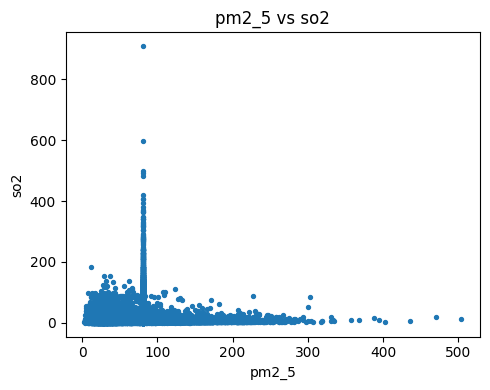

In [58]:
# Scatter plot PM2.5 vs PM10 else AQI vs NO2
pm25 = cols_found.get("PM2.5")
pm10 = cols_found.get("PM10")
aqi  = cols_found.get("AQI")
no2  = cols_found.get("NO2")

if pm25 and pm10 and pm25 in df.columns and pm10 in df.columns:
    xcol, ycol = pm25, pm10
    title = "PM2.5 vs PM10"
elif aqi and no2 and aqi in df.columns and no2 in df.columns:
    xcol, ycol = aqi, no2
    title = "AQI vs NO2"
else:
    xcol = TARGET
    # fallback pick any other numeric col
    others = [c for c in num_cols if c != TARGET]
    ycol = others[0] if others else TARGET
    title = f"{xcol} vs {ycol}"

plt.figure(figsize=(5,4))
plt.scatter(df[xcol].astype(float), df[ycol].astype(float), s=8)
plt.xlabel(xcol)
plt.ylabel(ycol)
plt.title(title)
plt.tight_layout()
plt.show()

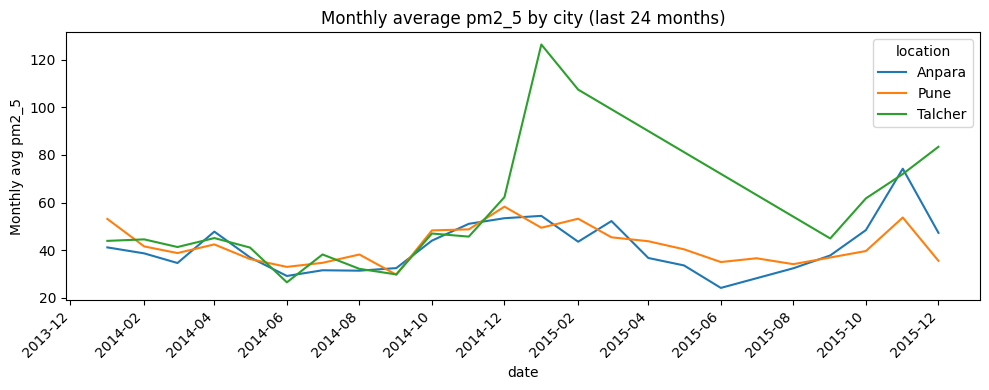

In [68]:
import pandas as pd
import matplotlib.dates as mdates
import seaborn as sns
import matplotlib.pyplot as plt

if city_col:
    monthly_city = (
        df[[city_col, date_col, TARGET]]
        .dropna(subset=[TARGET])
        .set_index(date_col)
        .groupby(city_col)[TARGET]
        .resample("MS")     # month start
        .mean()
        .reset_index()
    )

    # top 3 cities for clarity
    top_cities = monthly_city[city_col].value_counts().head(3).index.tolist()
    msmall = monthly_city[monthly_city[city_col].isin(top_cities)]

    # keep only the last 24 months (global window)
    end = msmall[date_col].max()
    cutoff = end - pd.DateOffset(months=24)  # 24-month window
    msmall_24 = msmall[msmall[date_col] > cutoff]

    fig, ax = plt.subplots(figsize=(10, 4))
    sns.lineplot(data=msmall_48, x=date_col, y=TARGET, hue=city_col, ax=ax)
    ax.set_title(f"Monthly average {TARGET} by city (last 24 months)")
    ax.set_ylabel(f"Monthly avg {TARGET}")
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2))
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
